# Análise de Sazonalidade de Incêndios no Brasil: Abordagem via Estatística Circular e Big Data

**Autor:** Rodrigo Lacerda Brito Neto  
*Cientista de Dados Geoespaciais | Ecologista da Paisagem (INPE)*  
[![LinkedIn](https://img.shields.io/badge/LinkedIn-Profile-blue?style=flat&logo=linkedin)](https://www.linkedin.com/in/datarod) [![GitHub](https://img.shields.io/badge/GitHub-Profile-black?style=flat&logo=github)](https://github.com/data-rod)

---

## 1. Introdução e Fundamentação Teórica

A modelagem de fenômenos ecológicos recorrentes, como a fenologia do fogo e ciclos de vegetação, apresenta um desafio estrutural quando abordada por métodos estatísticos lineares clássicos. Variáveis temporais de natureza cíclica não obedecem à topologia de um espaço Euclidiano linear ($\mathbb{R}$), mas sim à de uma circunferência unitária ($S^1$).

Neste contexto, a aplicação de estatística descritiva convencional (Média Aritmética, Variância) em dados anuais introduz distorções sistemáticas, uma vez que falha em reconhecer a continuidade entre o final e o início do ciclo calendário (condição de contorno periódica).

### Objetivos do Estudo
Este notebook propõe uma arquitetura escalável para determinar o **vetor médio de ocorrência de queimadas** (pico da temporada) e a **dispersão angular** (duração da temporada) para todas as Unidades da Federação do Brasil.

### Abordagem Metodológica: Estatística Direcional
Para preservar a integridade topológica dos dados, utilizamos a **Estatística Circular (ou Direcional)**. O pipeline consiste em:

1.  **Mapeamento Angular:** Transformação do domínio temporal $t$ (Dia do Ano - DOY) para o domínio angular $\theta$ (radianos $[0, 2\pi)$), considerando a correção para anos bissextos ($N=365.25$).
2.  **Momentos Circulares:** Cálculo do vetor resultante médio ($\bar{R}$) e do desvio padrão angular, fundamentais para caracterizar a concentração temporal dos eventos.
3.  **Inferência em Big Data:** Aplicação da *Aproximação Assintótica de Rayleigh* para testes de significância em grandes amostras ($N > 10^6$), superando limitações de overflow numérico comuns em bibliotecas padrão.

O processamento é realizado via integração direta com o **Google BigQuery**, garantindo eficiência na manipulação da série histórica do INPE (2006–Presente).

## 2. Engenharia de Dados e Ambiente Computacional

A arquitetura da solução adota um padrão híbrido de processamento, otimizado para manipular séries históricas extensas sem comprometer recursos locais. O pipeline é sustentado por três pilares tecnológicos:

1.  **Query Engine (Google BigQuery):** Utilizado para acesso ao *Data Lake* público do INPE (via `basedosdados`). A estratégia de *Server-side Filtering* é aplicada para realizar cortes temporais e seleção de colunas diretamente na infraestrutura da Google, reduzindo drasticamente o *overhead* de I/O e tráfego de rede.
2.  **Core Científico (`scipy` & `numpy`):** O Pandas nativo não oferece suporte a estatísticas direcionais. Portanto, utilizamos o módulo `scipy.stats` para o cálculo de momentos circulares (média vetorial e desvio padrão angular) e álgebra linear.
3.  **Visualização Polar (`plotly`):** Renderização de coordenadas polares interativas, permitindo a representação precisa de vetores de magnitude (concentração) e direção (sazonalidade).

In [11]:
# --- Instalação de Dependências (Caso necessário) ---
# Atualização de pacotes e instalação de dependências específicas
!apt-get update
!pip install kaleido==0.2.1  # Instalação do kaleido para renderização estática de gráficos


import numpy as np
import pandas as pd
from google.cloud import bigquery
from google.colab import auth
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import circmean, circstd
from datetime import datetime, timedelta
import warnings
import kaleido

# Configurações de UX para o Notebook
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.2f}'.format

print("Bibliotecas carregadas. Ambiente pronto para análise.")

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Get:2 https://cli.github.com/packages stable InRelease [3,917 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 3,917 B in 1s (3,666 B/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Bibliotecas carregadas. Ambiente pronto para análise.


## 3. Arquitetura Orientada a Objetos: Pipeline ETL

Para assegurar a modularidade e a reprodutibilidade do fluxo de trabalho, o pipeline foi encapsulado na classe `FireSeasonalityAnalyzer`. A arquitetura segue os princípios de *Object-Oriented Programming (OOP)*, centralizando a conexão com o Data Warehouse, a extração e o processamento estatístico.

### Estratégia de Aquisição de Dados
A interação com o BigQuery foi otimizada para minimizar a latência e custos de processamento. Em vez de transferir o *dataset* bruto para a memória local, aplicamos duas técnicas fundamentais de otimização de queries em sistemas OLAP:

1.  **Predicate Pushdown:** O filtro temporal (`data_hora >= '2006-01-01'`) é executado diretamente na engine do BigQuery, transferindo apenas o subconjunto de dados relevante.
2.  **Column Pruning:** Selecionamos estritamente as *features* necessárias (`data_hora`, `sigla_uf`), reduzindo drasticamente o volume de dados trafegados na rede.

In [12]:
class FireSeasonalityAnalyzer:
    """
    Classe responsável por extrair dados do BigQuery e realizar modelagem
    estatística circular. Definida de forma incremental para fins didáticos.
    """
    def __init__(self, project_id):
        self.project_id = project_id
        self.client = None
        self.df = None
        self.stats = None

    def authenticate(self):
        """Gerencia autenticação no ambiente Google Cloud/Colab."""
        auth.authenticate_user()
        self.client = bigquery.Client(project=self.project_id)
        print(f"Autenticado no projeto: {self.project_id}")

    def fetch_data(self, sample_limit=None):
        """
        Busca dados otimizados do BigQuery (Basedosdados).
        Query Otimizada: Seleciona apenas colunas essenciais para reduzir custos e latência.
        """
        query = """
        SELECT data_hora, sigla_uf
        FROM `basedosdados.br_inpe_queimadas.microdados`
        WHERE data_hora >= '2003-01-01'
        """
        if sample_limit:
            query += f" LIMIT {sample_limit}"

        print("Executando query no BigQuery...")
        if self.client:
            self.df = self.client.query(query).to_dataframe()
            print(f"Dados carregados na memória: {len(self.df)} registros.")
        else:
            print("Erro: Cliente não autenticado.")

## 4. Engenharia de Atributos: Mapeamento Topológico

A transformação de dados temporais lineares para o domínio circular é a etapa crítica deste pipeline. Não se trata apenas de formatação, mas de uma alteração na topologia dos dados para refletir a periodicidade do fenômeno.

### Correção de Deriva Temporal (Leap Year Drift)
Ao converter o Dia do Ano ($t$) para um ângulo ($\theta$), a escolha do denominador é determinante para a integridade de séries longas.
Em um intervalo de 18 anos (2006–2024), a utilização de um ano civil fixo ($N=365$) introduziria um erro cumulativo (*drift*) de aproximadamente 4,5 dias. Para mitigar esse deslocamento de fase, adotamos o ano juliano médio ($N=365.25$).

A função de mapeamento $\Phi: \mathbb{R} \to S^1$ é definida por:

$$
\theta_i = \text{DOY}_i \times \left( \frac{2\pi}{365.25} \right)
$$

Onde:
*   $\text{DOY}_i$: Dia do ano (1 a 366) da observação $i$.
*   $2\pi$: Círculo completo em radianos.
*   $\theta_i$: Variável angular resultante.

In [13]:
def preprocess(self):
    """
    Pipeline de transformação. Converte tempo linear em variáveis circulares.
    """
    if self.df is None:
        raise ValueError("Dados não carregados. Execute fetch_data() primeiro.")

    # 1. Conversão para Datetime
    self.df['data_hora'] = pd.to_datetime(self.df['data_hora'])
    self.df.dropna(subset=['data_hora', 'sigla_uf'], inplace=True)

    # 2. Extração do Dia do Ano (1-366)
    self.df['doy'] = self.df['data_hora'].dt.dayofyear

    # 3. Transformação Angular (Radianos)
    # 2*np.pi representa um círculo completo (360 graus)
    self.df['doy_rad'] = self.df['doy'] * (2 * np.pi / 365.25)

# Acoplando o método à classe (Monkey Patching para fins didáticos)
FireSeasonalityAnalyzer.preprocess = preprocess

## 5. Inferência Estatística e Estabilidade Numérica

A etapa de modelagem visa extrair parâmetros que descrevam a fenologia do fogo: o momento central de ocorrência (*peak timing*) e a duração da temporada (*seasonality strength*).

Em estatística direcional, tratamos cada ocorrência de incêndio como um vetor unitário $u_i$ na circunferência. A soma vetorial normalizada define o **Vetor Resultante Médio** ($\bar{R}$):

$$ \bar{R} = \frac{1}{N} \left| \sum_{j=1}^{N} e^{i\theta_j} \right| $$

Onde $\bar{R} \in [0, 1]$.
*   $\bar{R} \to 1$: Alta concentração (sazonalidade forte).
*   $\bar{R} \to 0$: Dispersão uniforme (ausência de sazonalidade).

### Desafio Computacional: A Aproximação de Rayleigh
Para validar a significância estatística da sazonalidade (rejeitar a hipótese nula $H_0$ de uniformidade), utilizamos o **Teste de Rayleigh**.

Contudo, o cálculo exato do p-valor envolve séries de expansão que sofrem de *overflow* numérico quando $N > 10^6$ (cenário comum em dados de satélite). Para contornar isso, implementamos a **Aproximação Assintótica para Grandes Amostras** (Mardia & Jupp, 2000), onde a estatística de teste $Z$ converge para uma distribuição qui-quadrado:

$$ P \approx \exp(-N \bar{R}^2) $$

Esta formulação garante estabilidade numérica e eficiência computacional em ambiente Big Data.

REFERÊNCIA:
Mardia, K. V., & Jupp, P. E. (2000). Directional Statistics. John Wiley & Sons. Seção 6.3.1: "The Rayleigh Test - Large sample approximation".

Link (DOI): https://doi.org/10.1002/9780470316979

Link (Google Books): https://books.google.com.br/books?id=Zt8gVfWcQyYC&pg=PA94


In [14]:
def _calculate_circular_stats_group(self, group):
    """
    Método auxiliar: Calcula estatísticas vetoriais para um grupo (UF).

    FUNDAMENTAÇÃO CIENTÍFICA (Big Data):
    Para grandes volumes de dados (N > 10^6), a computação exata de P-valores via séries
    infinitas torna-se instável numericamente. Este método implementa a Aproximação
    Assintótica de Rayleigh, conforme estabelecido na literatura clássica.

    A estatística 2*N*(R_bar^2) converge para uma distribuição Qui-Quadrado com 2 graus
    de liberdade (chi2_2) quando N tende ao infinito.

    REFERÊNCIA:
    Mardia, K. V., & Jupp, P. E. (2000). Directional Statistics. John Wiley & Sons.
    Seção 6.3.1: "The Rayleigh Test - Large sample approximation".
    Link (DOI): https://doi.org/10.1002/9780470316979
    Link (Google Books): https://books.google.com.br/books?id=Zt8gVfWcQyYC&pg=PA94
    """
    angles = group.values
    n = len(angles)

    # 1. Estatísticas Circulares Básicas (Scipy)
    mean_rad = circmean(angles, high=2*np.pi, low=0)
    std_rad = circstd(angles, high=2*np.pi, low=0)

    # 2. Cálculo do Vetor Resultante Médio (R)
    sin_sum = np.sum(np.sin(angles))
    cos_sum = np.sum(np.cos(angles))
    R_bar = np.sqrt(sin_sum**2 + cos_sum**2) / n

    # 3. Teste de Rayleigh (Aproximação Assintótica para N > 50)
    # Z é a estatística de teste. Quanto maior Z, menor o P-valor.
    if n > 0:
        z = n * (R_bar ** 2)
        pval = np.exp(-z)
    else:
        pval = 1.0

    return pd.Series({
        'mean_rad': mean_rad,
        'std_rad': std_rad,
        'n': n,
        'p_value': pval,
        'r_vector': R_bar
    })

def analyze(self):
    """Orquestra a aplicação da estatística circular por Estado."""
    print("Calculando estatísticas circulares por UF (Engine: Big Data)...")

    self.stats = self.df.groupby('sigla_uf')['doy_rad'].apply(
        lambda x: self._calculate_circular_stats_group(x)
    ).unstack()

    # Reverte Radianos para Dias
    self.stats['mean_doy'] = self.stats['mean_rad'] * (365.25 / (2 * np.pi))
    self.stats['std_days'] = self.stats['std_rad'] * (365.25 / (2 * np.pi))

    # Data Legível do Pico
    base_date = datetime(2023, 1, 1)
    self.stats['peak_date'] = self.stats['mean_doy'].apply(
        lambda x: base_date + timedelta(days=int(x) - 1)
    )
    return self.stats

# Acoplando a correção
FireSeasonalityAnalyzer._calculate_circular_stats_group = _calculate_circular_stats_group
FireSeasonalityAnalyzer.analyze = analyze

## 6. Visualização Fenológica: Coordenadas Polares e Small Multiples

A representação linear de dados cíclicos frequentemente introduz descontinuidades visuais artificiais (o "abismo" entre 31 de dezembro e 1º de janeiro). Para preservar a topologia dos dados e permitir a comparação simultânea das 27 Unidades da Federação, adotamos uma abordagem de **Small Multiples em Coordenadas Polares**.

Neste sistema gráfico, mapeamos os momentos estatísticos calculados anteriormente em componentes visuais geométricos:

1.  **Vetor Direcional (Linha Vermelha):** Representa a Média Circular ($\bar{\theta}$). Sua orientação indica o **pico fenológico** da temporada de fogo.
2.  **Setor de Dispersão (Área Sombreada):** Representa o Desvio Padrão Circular ($\sigma$). A amplitude angular deste setor quantifica a **janela temporal de queima**:
    *   *Setor Agudo:* Sazonalidade concentrada (ex: Cerrado/Amazônia).
    *   *Setor Obtuso:* Sazonalidade difusa ou multimodal.


In [15]:
def plot_seasonality_grid(stats_df):
    """
    Gera um grid de gráficos polares.
    Visualiza a média (direção) e o desvio padrão (dispersão/largura) das queimadas.
    """
    ufs = sorted(stats_df.index.unique())
    n_cols = 5
    n_rows = -(-len(ufs) // n_cols)

    # Layout do Grid
    fig = make_subplots(
        rows=n_rows, cols=n_cols,
        specs=[[{'type': 'polar'}]*n_cols]*n_rows,
        subplot_titles=[f"<b>{uf}</b>" for uf in ufs],
        vertical_spacing=0.07, horizontal_spacing=0.06
    )

    for i, uf in enumerate(ufs):
        row = (i // n_cols) + 1
        col = (i % n_cols) + 1
        data = stats_df.loc[uf]

        # Conversão: Dias -> Graus (0-360) para o Plotly
        mean_deg = (data['mean_doy'] / 365.25) * 360
        std_deg = (data['std_days'] / 365.25) * 360

        # 1. A "Fatia" de Dispersão (Desvio Padrão)
        fig.add_trace(go.Barpolar(
            r=[1], # Raio fixo para padronização visual
            theta=[mean_deg],
            width=[std_deg * 2], # Amplitude de +/- 1 desvio padrão
            marker_color='rgba(255, 200, 0, 0.4)',
            marker_line_width=0,
            hoverinfo='text',
            text=f"Janela de Queima (Std Dev): +/- {data['std_days']:.1f} dias"
        ), row=row, col=col)

        # 2. O Vetor Direcional (Média)
        fig.add_trace(go.Scatterpolar(
            r=[0, 1],
            theta=[0, mean_deg],
            mode='lines',
            line=dict(color='#db0303', width=3),
            name='Média',
            hoverinfo='text',
            text=f"Pico Médio: {data['peak_date'].strftime('%d/%b')}<br>Amostras: {int(data['n'])}"
        ), row=row, col=col)

    # Estética Final
    fig.update_layout(
        title_text="<b>Sazonalidade das Queimadas por UF (2003-2025)</b><br><sup>Média Circular (Linha Vermelha) e Desvio Padrão Circular (Setor Amarelo) | Fonte: INPE/Base dos Dados</sup>",
        title_font_size=20,
        height=300 * n_rows, width=1100,
        showlegend=False,
        template="plotly_white",
        paper_bgcolor="#f8f9fa"
    )

    # Configuração do Relógio (Meses)
    fig.update_polars(
        radialaxis=dict(visible=False, range=[0, 1]),
        angularaxis=dict(
            direction='clockwise', period=360,
            tickmode='array',
            tickvals=np.linspace(0, 330, 12),
            ticktext=['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'],
            tickfont=dict(size=10)
        )
    )

    fig.show("png")

## 7. Orquestração do Pipeline e Execução

Esta seção consolida os módulos definidos anteriormente em um fluxo de execução contínuo. O pipeline integra as etapas de Autenticação, ETL (Extração, Transformação e Carga), Modelagem Estatística e Visualização Analítica.

> **Pré-requisito:** Certifique-se de definir a constante `GCP_PROJECT_ID` com um identificador de projeto válido no Google Cloud Platform.

--- Iniciando Análise de Sazonalidade ---
Autenticado no projeto: GCP_PROJECT_ID
Executando query no BigQuery...
Dados carregados na memória: 17542900 registros.
Calculando estatísticas circulares por UF (Engine: Big Data)...

Top 5 Estados com pico de queimadas mais tardio (Final do ano):


,peak_date,std_days,n
sigla_uf,,,
AL,2023-12-31,57.76,30531.00
PB,2023-11-20,46.80,59239.00
RN,2023-11-18,54.22,41777.00
CE,2023-11-15,39.62,287739.00
PE,2023-11-14,52.81,102520.00


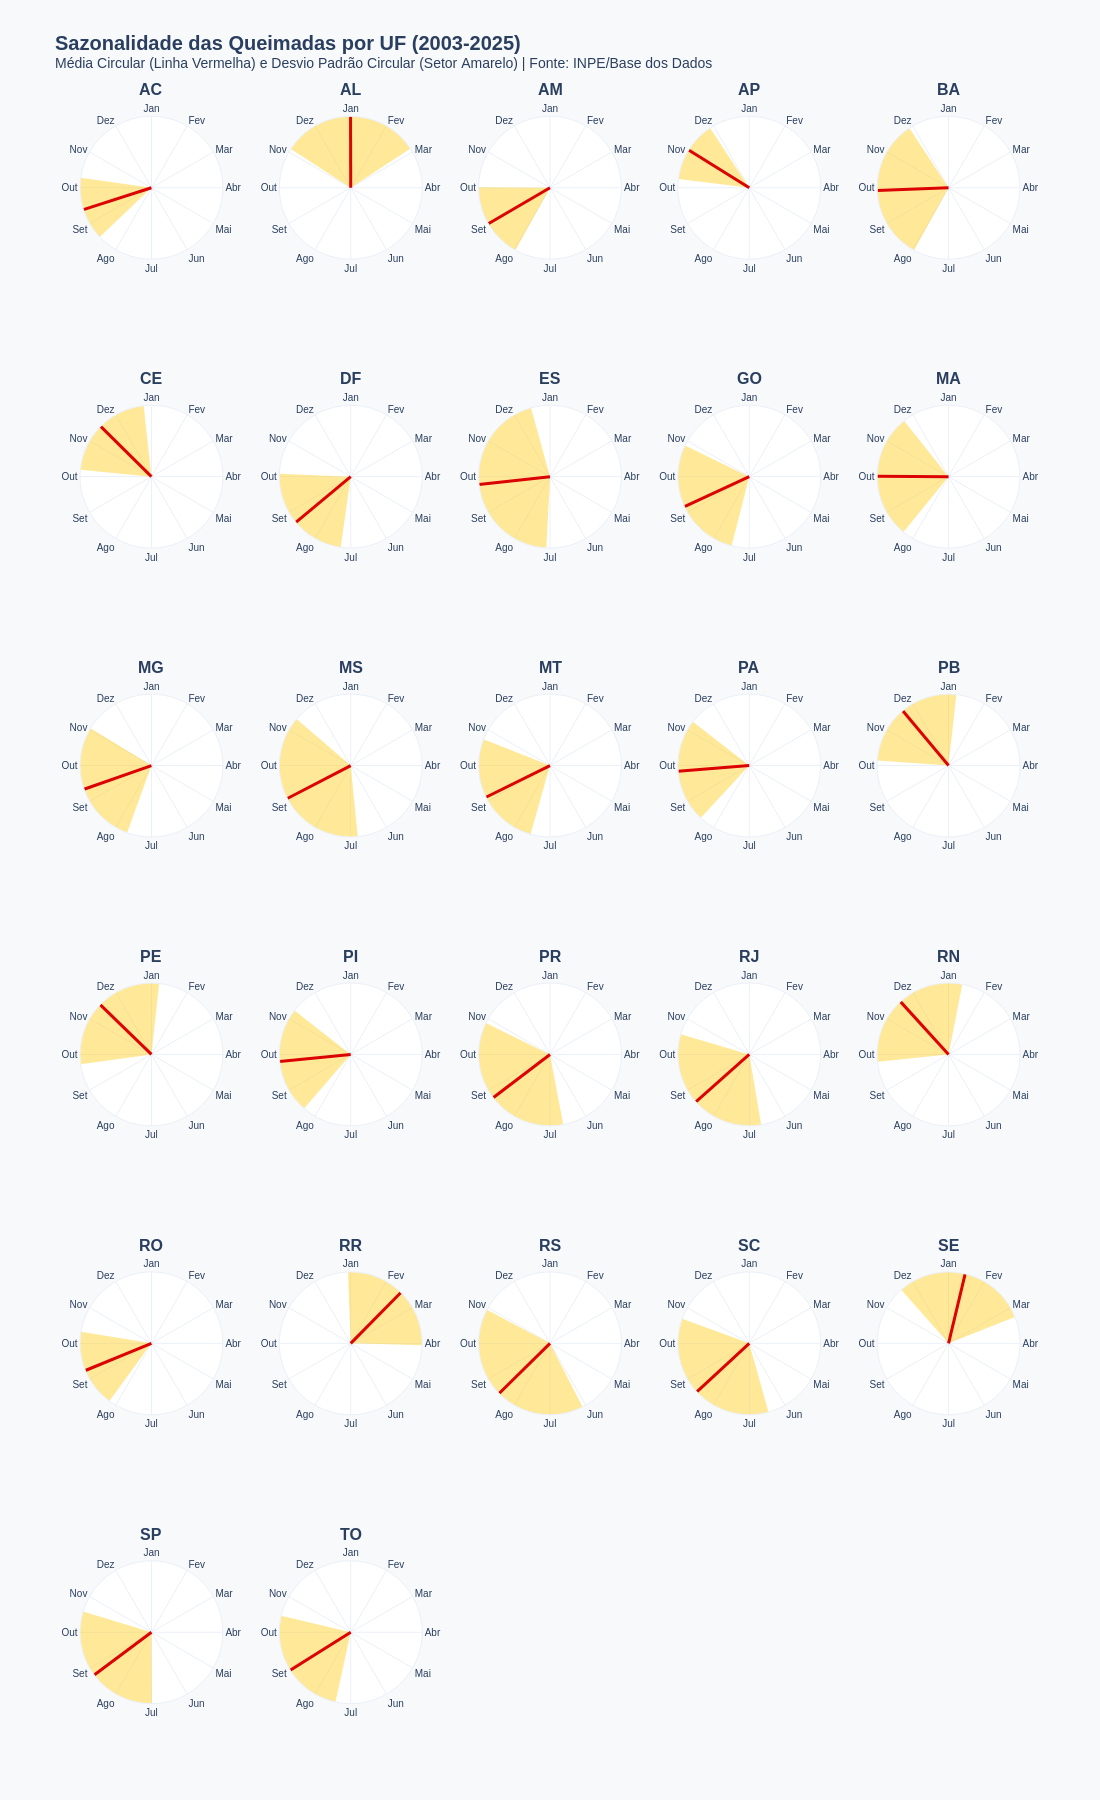

In [16]:
# --- Parâmetros de Execução ---
# Substitua pelo seu ID de projeto no Google Cloud
PROJECT_ID = 'GCP_PROJECT_ID'

try:
    print("--- Iniciando Análise de Sazonalidade ---")

    # 1. Instanciação e Autenticação
    analyzer = FireSeasonalityAnalyzer(PROJECT_ID)
    analyzer.authenticate()

    # 2. Extração de Dados (ETL)
    analyzer.fetch_data()

    # 3. Processamento Matemático
    analyzer.preprocess()
    results = analyzer.analyze()

    # 4. Insights Tabulares
    print("\nTop 5 Estados com pico de queimadas mais tardio (Final do ano):")
    # Ordenação por Dia do Ano (pico) decrescente
    top_late_season = results.sort_values('mean_doy', ascending=False)[['peak_date', 'std_days', 'n']]
    display(top_late_season.head())

    # 5. Visualização Gráfica
    plot_seasonality_grid(results)

except Exception as e:
    print(f"\nErro Crítico no Pipeline: {e}")
    # Debug: Verifica estado dos dados caso ocorra erro
    if 'analyzer' in locals() and analyzer.df is not None:
        print("Status do DataFrame:", analyzer.df.info())

## 8. Validação de Hipóteses e Sensibilidade Estatística

Nesta etapa, avaliamos a robustez dos resultados aplicando o Teste de Rayleigh. O objetivo é testar a Hipótese Nula ($H_0$) de que os focos de calor estão distribuídos uniformemente ao longo do círculo (sem sazonalidade).

### O Paradoxo de Grandes Amostras (Large Sample Size)
Em cenários de Big Data, onde $N$ frequentemente excede $10^6$, a potência do teste estatístico é maximizada. Consequentemente, o erro padrão tende a zero e o **P-valor converge assintoticamente para zero** para qualquer desvio mínimo da uniformidade.

Portanto, a interpretação deve ser matizada:
1.  **$p \approx 0$:** Confirma que a distribuição **não é aleatória**. Existe um padrão sistêmico governando o fenômeno.
2.  **Magnitude ($\bar{R}$) e Desvio ($\sigma$):** Uma vez rejeitada a $H_0$, essas métricas tornam-se os verdadeiros indicadores da **intensidade da sazonalidade**.

In [17]:
def evaluate_significance(stats_df):
    """
    Gera relatório de significância estatística.
    Interpreta P-valores próximos de zero como Sazonalidade Forte.
    """
    eval_df = stats_df.copy()

    # Classificação: P-valores muito baixos indicam alta certeza estatística
    eval_df['status'] = eval_df['p_value'].apply(
        lambda p: '✅ Sazonalidade Forte' if p < 0.001 else
                  ('⚠ Sazonalidade Moderada' if p < 0.05 else '❌ Distribuição Uniforme')
    )

    # Seleção e Ordenação
    display_cols = ['peak_date', 'std_days', 'n', 'p_value', 'status']
    report = eval_df.sort_values(['p_value', 'std_days'], ascending=[True, True])[display_cols]

    print("--- Relatório de Significância Estatística ---")
    print(f"Total de UFs: {len(report)}")

    # Formatação condicional para facilitar a leitura
    try:
        display(report.style.format({
            'p_value': '{:.2e}', # Notação científica para números muito pequenos
            'std_days': '{:.1f}',
            'n': '{:.0f}'
        }).background_gradient(subset=['std_days'], cmap='YlOrRd'))
    except:
        print(report)

# Execução
if 'results' in locals():
    evaluate_significance(results)
else:
    print("Por favor, execute analyzer.analyze() primeiro.")

--- Relatório de Significância Estatística ---
Total de UFs: 27


,peak_date,std_days,n,p_value,status
sigla_uf,,,,,
AP,2023-11-02 00:00:00,25.2,130769,0.00e+00,✅ Sazonalidade Forte
AC,2023-09-12 00:00:00,26.2,370988,0.00e+00,✅ Sazonalidade Forte
AM,2023-08-31 00:00:00,31.1,1415927,0.00e+00,✅ Sazonalidade Forte
RO,2023-09-08 00:00:00,32.1,913600,0.00e+00,✅ Sazonalidade Forte
CE,2023-11-15 00:00:00,39.6,287739,0.00e+00,✅ Sazonalidade Forte
DF,2023-08-21 00:00:00,42.8,12183,0.00e+00,✅ Sazonalidade Forte
PA,2023-09-26 00:00:00,43.1,3711774,0.00e+00,✅ Sazonalidade Forte
PI,2023-09-25 00:00:00,44.3,809092,0.00e+00,✅ Sazonalidade Forte
TO,2023-08-29 00:00:00,46.2,1066580,0.00e+00,✅ Sazonalidade Forte


## 9. Opção secundária de visualização
 3 páginas de 9 estados

--- Gerando Card 1/3 para o Carrossel ---


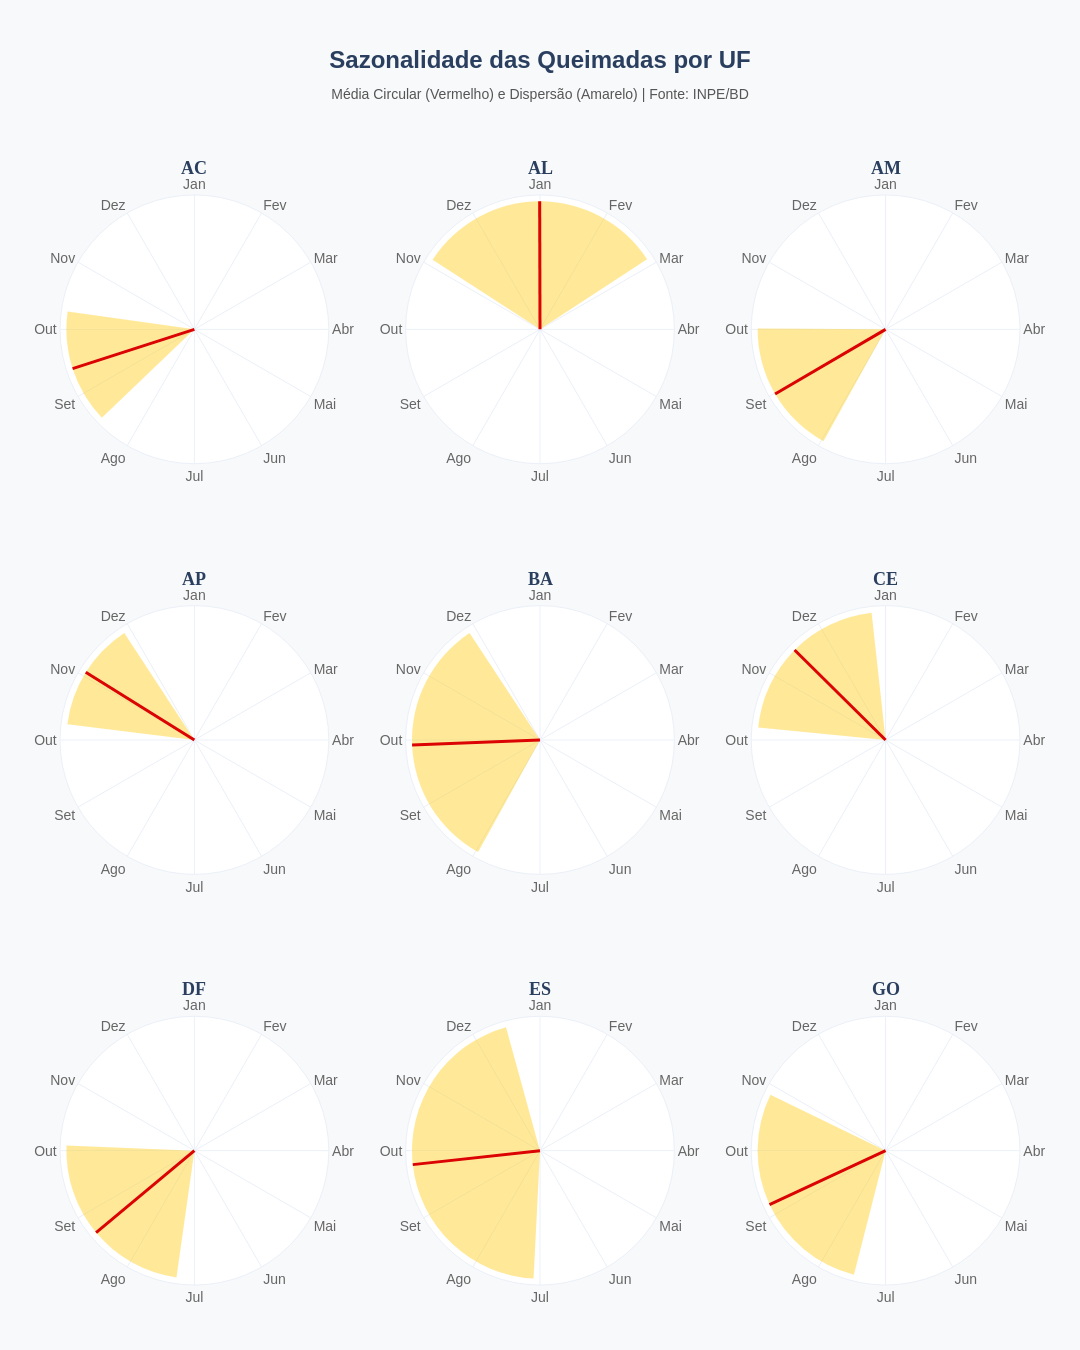

--- Gerando Card 2/3 para o Carrossel ---


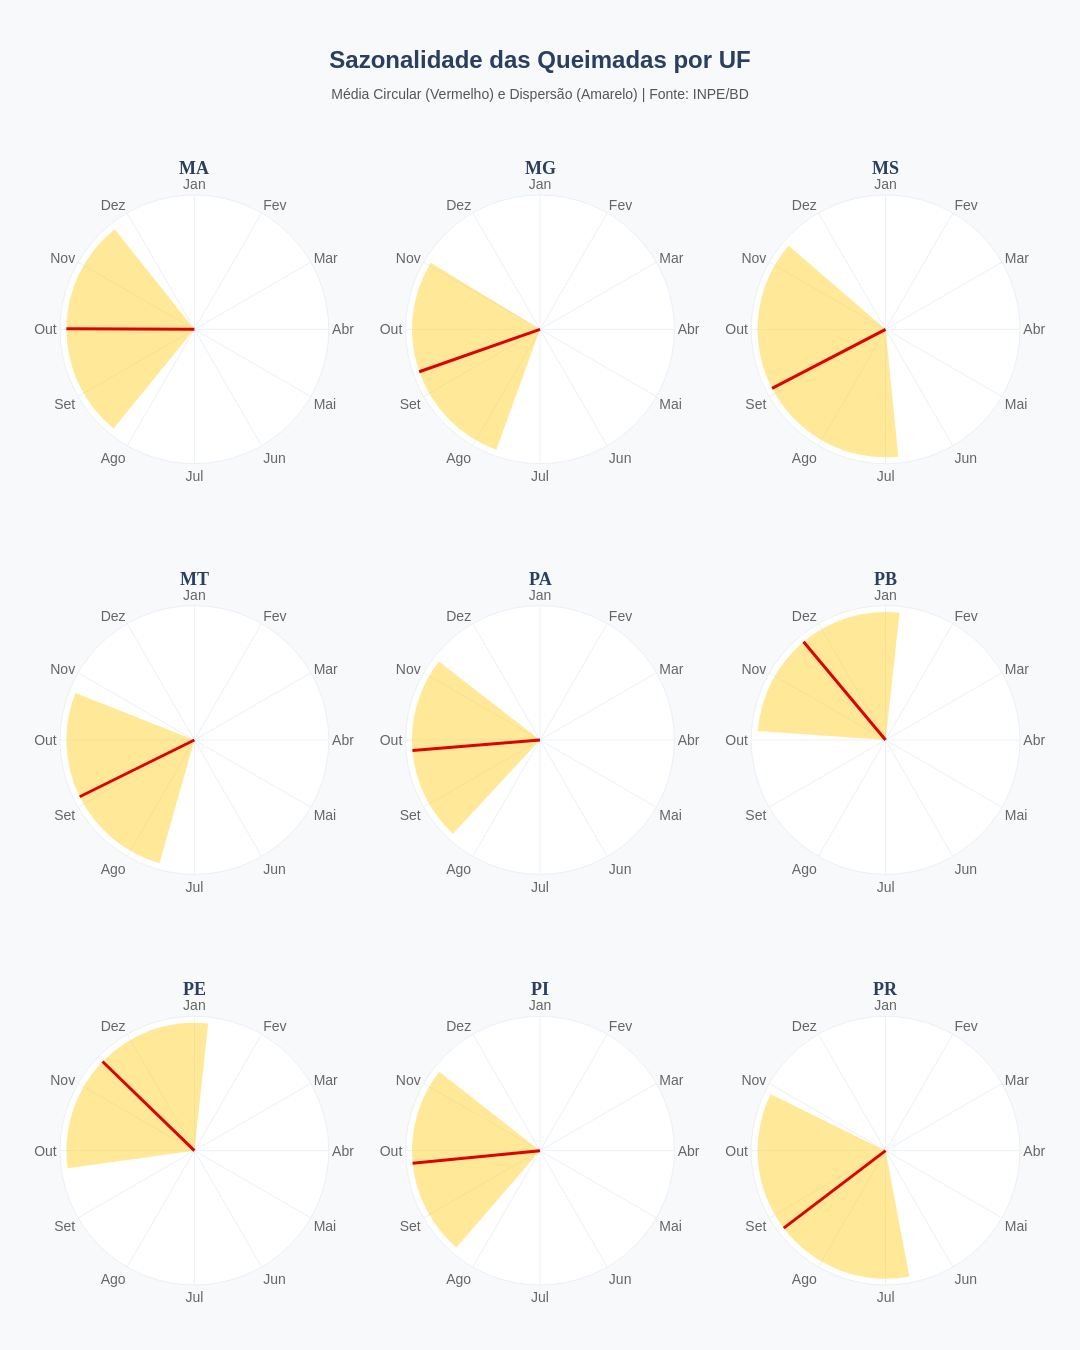

--- Gerando Card 3/3 para o Carrossel ---


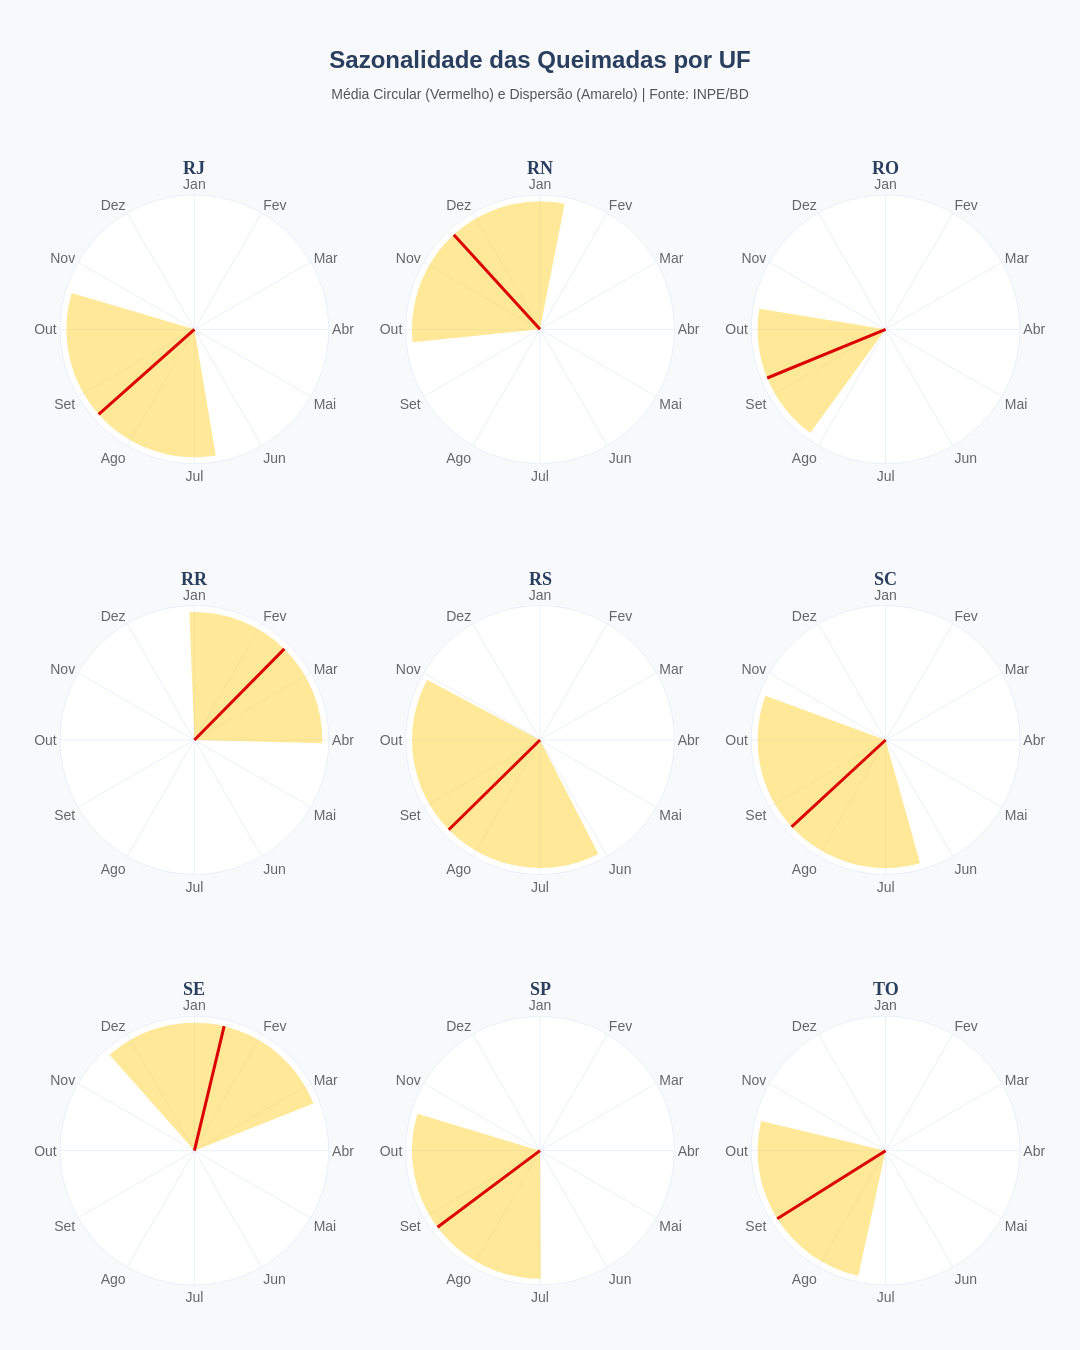

In [18]:
def generate_carousel_figures_optimized(stats_df):
    """
    Gera 3 figuras (3x3) otimizadas para Carrossel LinkedIn/Instagram (1080x1350).
    Corrige problemas de sobreposição de texto e espaçamento (diagramação profissional).
    """
    # 1. Preparação dos dados
    ufs = sorted(stats_df.index.unique())
    chunks = [ufs[i:i + 9] for i in range(0, len(ufs), 9)]

    figures = []

    for page_num, chunk_ufs in enumerate(chunks):
        # 2. Grid com Espaçamento Aumentado (O segredo do layout limpo)
        # vertical_spacing=0.13 é vital para separar o título do estado do label 'Jan'
        fig = make_subplots(
            rows=3, cols=3,
            specs=[[{'type': 'polar'}]*3]*3,
            subplot_titles=[f"<b>{uf}</b>" for uf in chunk_ufs],
            vertical_spacing=0.1,
            horizontal_spacing=0.08
        )

        for i, uf in enumerate(chunk_ufs):
            row = (i // 3) + 1
            col = (i % 3) + 1
            data = stats_df.loc[uf]

            # Conversão Matemática (Idêntica à aprovada)
            mean_deg = (data['mean_doy'] / 365.25) * 360
            std_deg = (data['std_days'] / 365.25) * 360

            # Trace 1: Desvio Padrão (Fatia Amarela)
            fig.add_trace(go.Barpolar(
                r=[1], theta=[mean_deg], width=[std_deg * 2],
                marker_color='rgba(255, 200, 0, 0.4)', # Cor Aprovada
                marker_line_width=0,
                showlegend=False,
                hoverinfo='skip'
            ), row=row, col=col)

            # Trace 2: Vetor Média (Linha Vermelha)
            fig.add_trace(go.Scatterpolar(
                r=[0, 1], theta=[0, mean_deg], mode='lines',
                line=dict(color='#db0303', width=3), # Cor Aprovada
                showlegend=False,
                hoverinfo='text',
                text=f"<b>{uf}</b><br>Pico: {data['peak_date'].strftime('%d/%b')}"
            ), row=row, col=col)

        # 3. Diagramação Profissional (Layout Engine)
        fig.update_layout(
            # Título com quebra de linha <br> e subtítulo menor <sup> para hierarquia
            title_text="<b>Sazonalidade das Queimadas por UF</b><br><span style='font-size: 14px; color: #555;'>Média Circular (Vermelho) e Dispersão (Amarelo) | Fonte: INPE/BD</span>",
            title_x=0.5, # Centralizado
            title_y=0.95, # Levemente mais alto para dar respiro
            title_font_size=24,

            # Dimensões exatas para Social Media (4:5 Portrait)
            width=1080,
            height=1350,

            template="plotly_white",
            paper_bgcolor="#f8f9fa", # Cor de fundo aprovada

            # Margens: Topo generoso (180px) para acomodar título e subtítulo sem colidir
            margin=dict(t=180, b=50, l=60, r=60)
        )

        # 4. Ajuste dos Eixos Polares (Evita sobreposição com Títulos)
        fig.update_polars(
            radialaxis=dict(visible=False, range=[0, 1.05]), # 1.05 cria um 'padding' interno
            angularaxis=dict(
                direction='clockwise',
                period=360,
                tickmode='array',
                tickvals=np.linspace(0, 330, 12),
                ticktext=['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'],
                # Fonte reduzida para 10px para não brigar com o título "AC/AL/AM"
                tickfont=dict(size=14, color='#666')
            )
        )

        # Ajuste específico para os títulos dos subplots (States)
        fig.update_annotations(font_size=18, font_family="Arial Black")

        print(f"--- Gerando Card {page_num + 1}/3 para o Carrossel ---")
        fig.show("png")
        figures.append(fig)

# Executar
if 'results' in locals():
    generate_carousel_figures_optimized(results)
else:
    print("Execute a análise primeiro.")

## 10. Análise Multivariada: A Dinâmica Eco-Climática (Fogo vs. Chuva)

A análise isolada dos focos de calor, embora descritiva, é insuficiente para compreender os *drivers* ambientais do fogo. Para elevar o nível da modelagem, integramos uma segunda variável cíclica ao sistema: a **Precipitação Pluviométrica**.

Neste etapa, o desafio matemático aumenta: enquanto o fogo é tratado como eventos discretos (contagem de pontos), a chuva é uma variável contínua de magnitude. Para compará-las no mesmo espaço vetorial, aplicamos dois métodos distintos de momentos circulares:

1.  **Vetor Fogo (Eventos):** Baseado na frequência angular de ocorrências.
2.  **Vetor Chuva (Magnitude Ponderada):** A direção média ($\bar{\theta}_{rain}$) é ponderada pelo volume precipitado ($mm$). Dias com chuvas torrenciais "puxam" o vetor com mais força do que dias de garoa.


> **Abaixo:** Execução da classe atualizada para processar ambas as variáveis e gerar a visualização integrada (Blue & Red Layers).

--- Iniciando Análise Integrada (Fogo + Chuva) ---
Autenticado no projeto: GCP_PROJECT_ID
Executando query no BigQuery...
Dados carregados na memória: 17542900 registros.
Calculando estatísticas circulares (Fogo vs Chuva)...

Top 5 Estados com pico de queimadas mais tardio:


,peak_date_fire,peak_date_rain,std_days_fire,n
sigla_uf,,,,
AL,2023-12-31,2023-01-30,57.76,30531.00
PB,2023-11-20,2023-01-15,46.80,59239.00
RN,2023-11-18,2023-01-31,54.22,41777.00
CE,2023-11-15,2023-01-05,39.62,287739.00
PE,2023-11-14,2023-01-20,52.81,102520.00


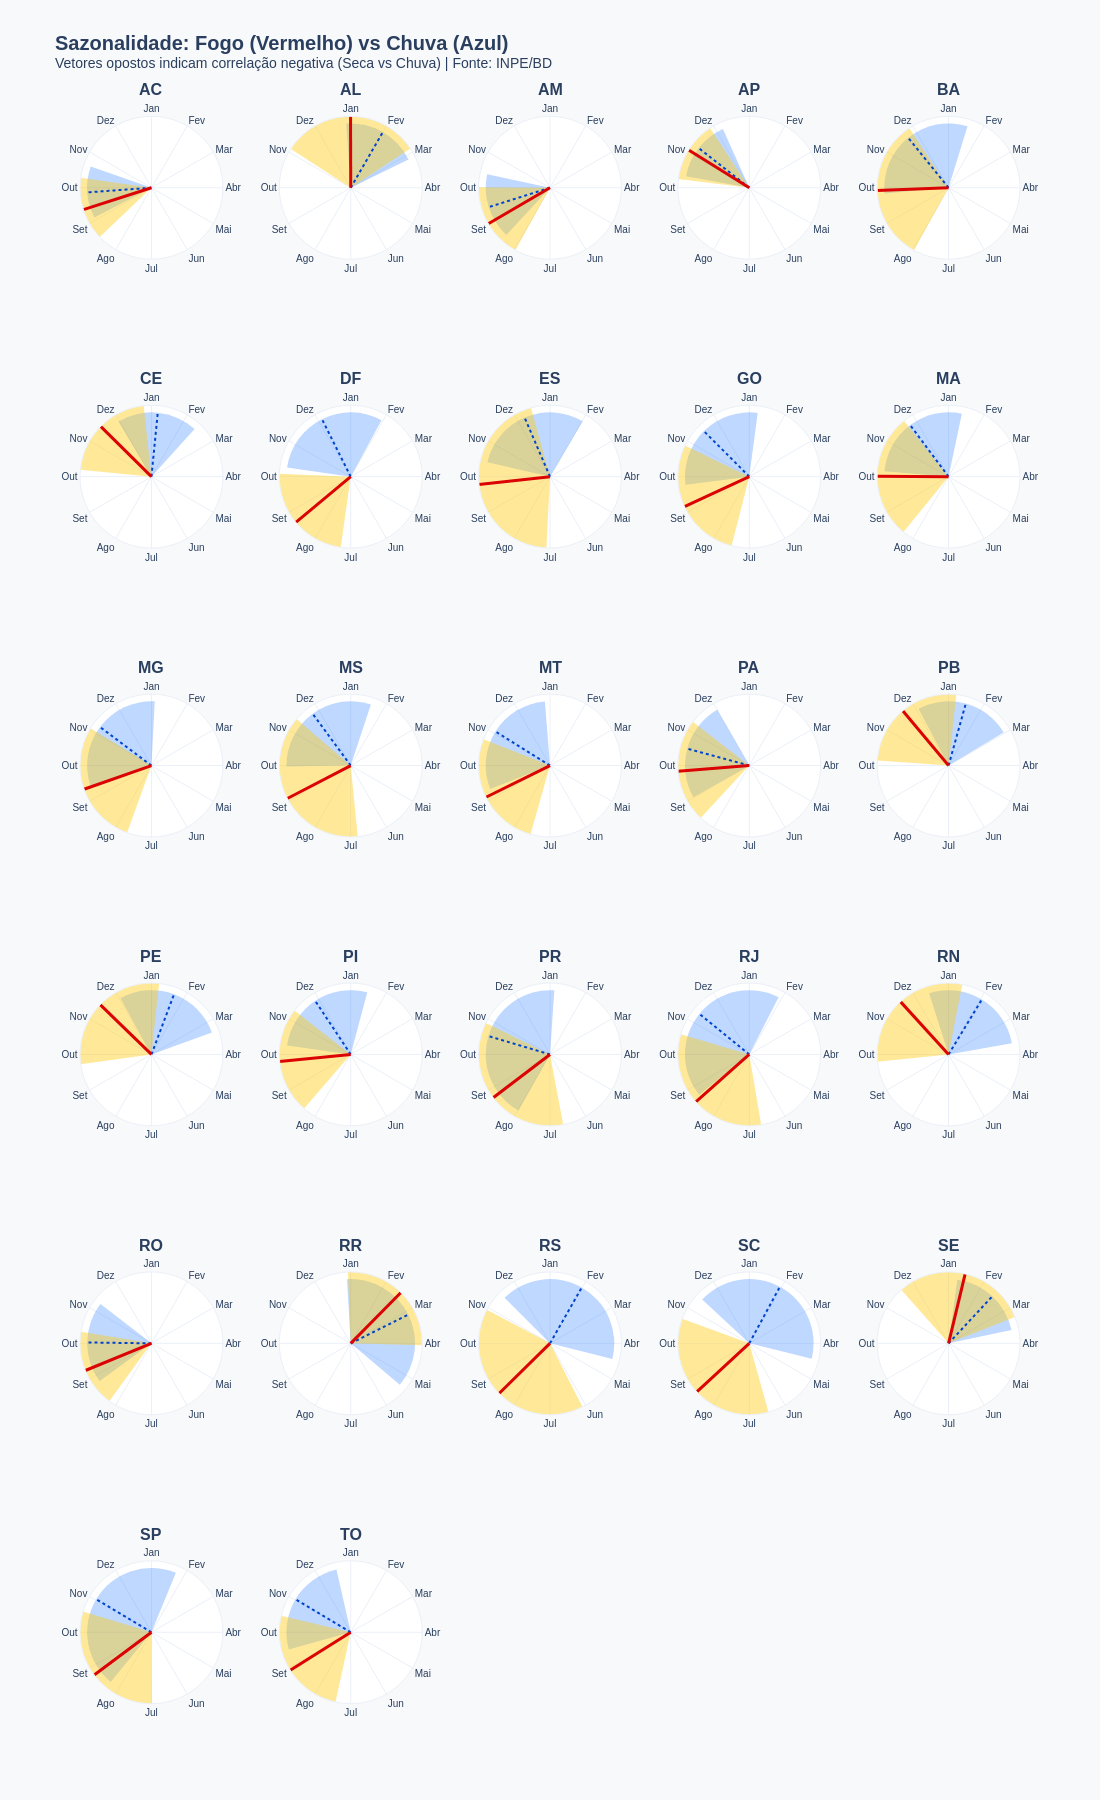

--- Relatório de Sazonalidade: Fogo vs. Chuva ---
Total de UFs analisadas: 27


,peak_date_fire,std_days_fire,peak_date_rain,std_days_rain,n,status
sigla_uf,,,,,,
AP,2023-11-02 00:00:00,25.2,2023-11-08 00:00:00,28.1,130769,✅ Sazonalidade Forte
AC,2023-09-12 00:00:00,26.2,2023-09-26 00:00:00,23.7,370988,✅ Sazonalidade Forte
AM,2023-08-31 00:00:00,31.1,2023-09-13 00:00:00,30.2,1415927,✅ Sazonalidade Forte
RO,2023-09-08 00:00:00,32.1,2023-10-01 00:00:00,37.4,913600,✅ Sazonalidade Forte
CE,2023-11-15 00:00:00,39.6,2023-01-05 00:00:00,37.1,287739,✅ Sazonalidade Forte
DF,2023-08-21 00:00:00,42.8,2023-12-04 00:00:00,56.0,12183,✅ Sazonalidade Forte
PA,2023-09-26 00:00:00,43.1,2023-10-16 00:00:00,45.5,3711774,✅ Sazonalidade Forte
PI,2023-09-25 00:00:00,44.3,2023-11-27 00:00:00,49.2,809092,✅ Sazonalidade Forte
TO,2023-08-29 00:00:00,46.2,2023-11-01 00:00:00,47.0,1066580,✅ Sazonalidade Forte


--- Gerando Card 1/3 ---


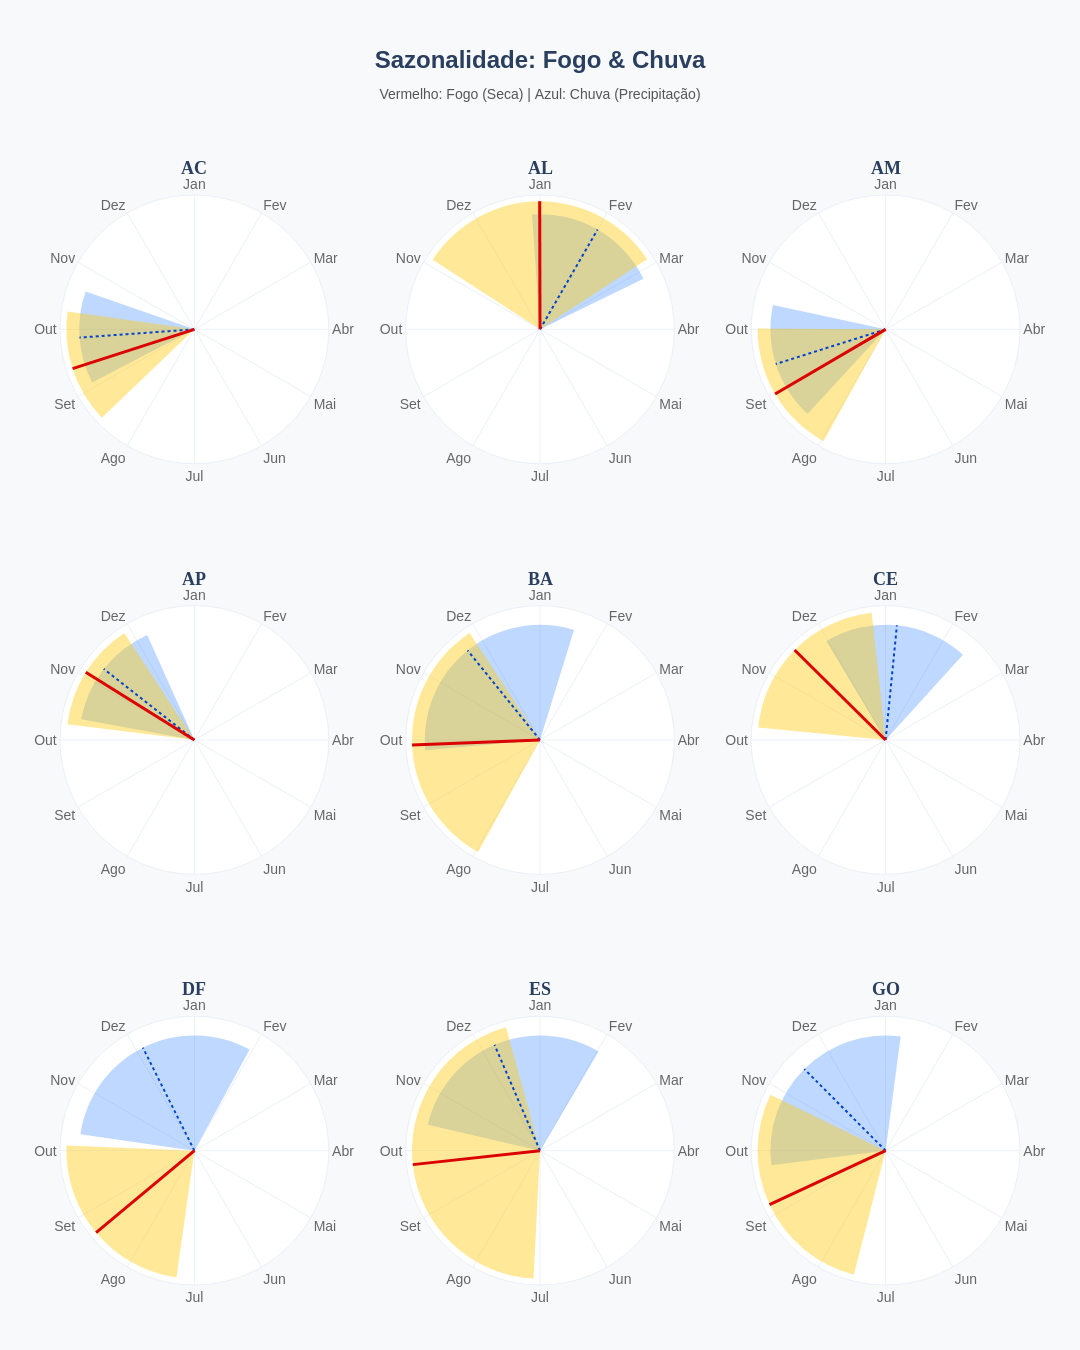

--- Gerando Card 2/3 ---


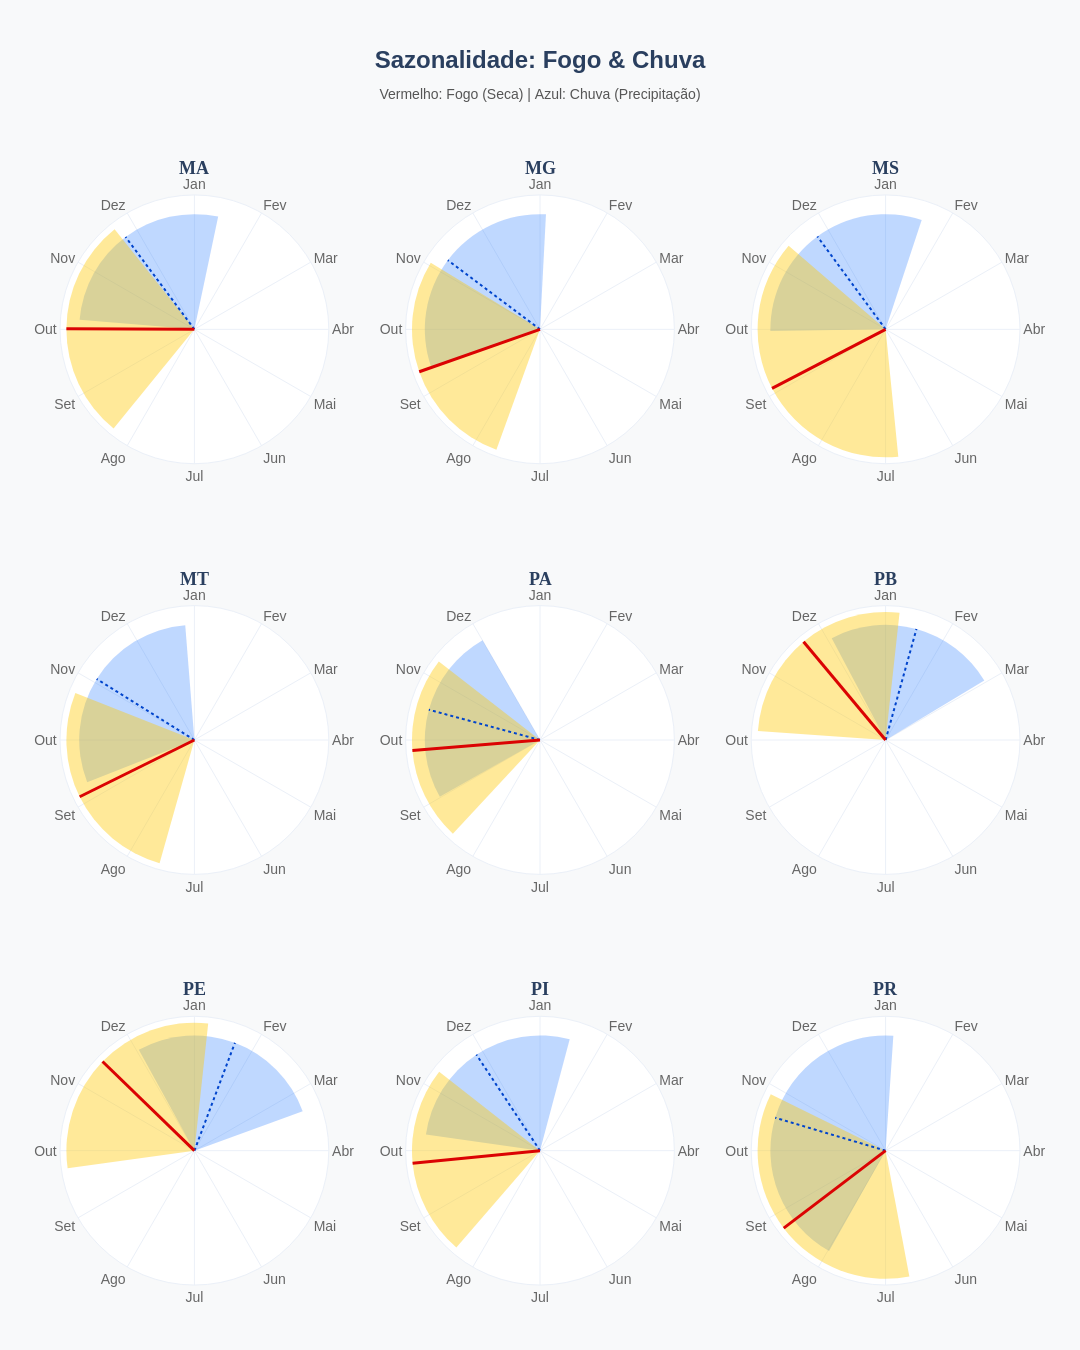

--- Gerando Card 3/3 ---


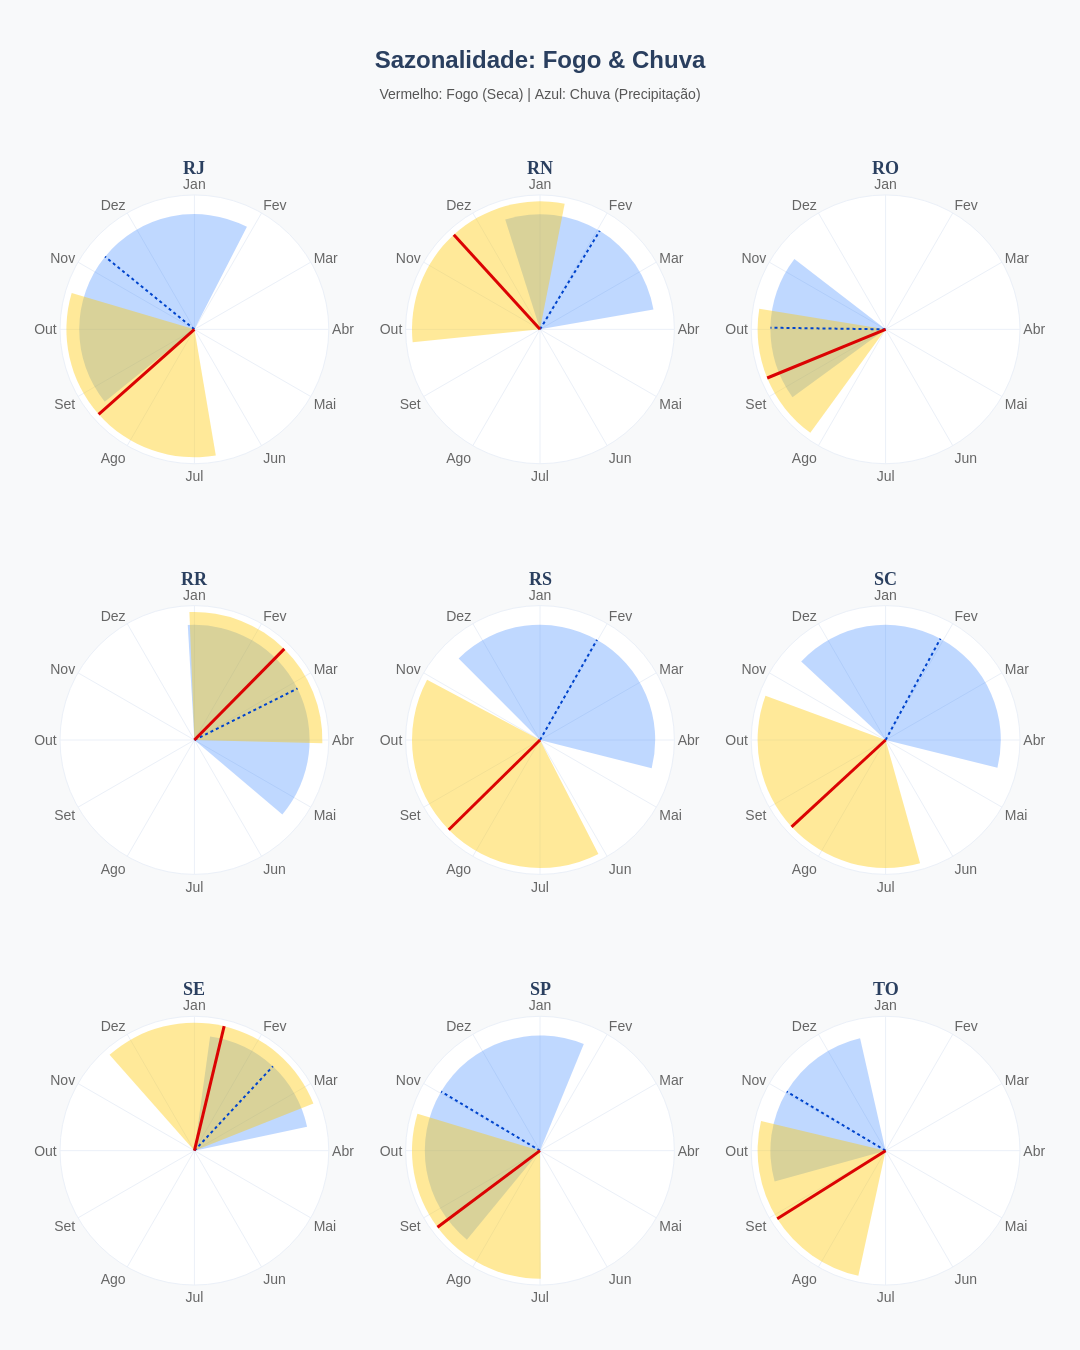

In [19]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
from google.cloud import bigquery
from google.colab import auth
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import circmean, circstd
from datetime import datetime, timedelta
import warnings

# Configurações
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.2f}'.format

# --- Parâmetros de Execução ---
class FireSeasonalityAnalyzer:
    """
    Classe responsável por extrair dados do BigQuery e realizar modelagem
    estatística circular para FOGO e PRECIPITAÇÃO.
    """
    def __init__(self, project_id):
        self.project_id = project_id
        self.client = None
        self.df = None
        self.stats = None

    def authenticate(self):
        auth.authenticate_user()
        self.client = bigquery.Client(project=self.project_id)
        print(f"Autenticado no projeto: {self.project_id}")

    def fetch_data(self, sample_limit=None):
        """
        Busca dados otimizados do BigQuery incluindo PRECIPITAÇÃO.
        """
        # Adicionei 'precipitacao' na seleção
        query = """
        SELECT data_hora, sigla_uf, precipitacao
        FROM `basedosdados.br_inpe_queimadas.microdados`
        WHERE data_hora >= '2003-01-01'
        """
        if sample_limit:
            query += f" LIMIT {sample_limit}"

        print("Executando query no BigQuery...")
        if self.client:
            self.df = self.client.query(query).to_dataframe()
            print(f"Dados carregados na memória: {len(self.df)} registros.")
        else:
            print("Erro: Cliente não autenticado.")

    def preprocess(self):
        if self.df is None:
            raise ValueError("Dados não carregados.")

        # 1. Conversão para Datetime
        self.df['data_hora'] = pd.to_datetime(self.df['data_hora'])
        self.df.dropna(subset=['data_hora', 'sigla_uf'], inplace=True)

        # Trata nulos na precipitação como 0
        self.df['precipitacao'] = self.df['precipitacao'].fillna(0)

        # 2. Transformação Angular
        self.df['doy'] = self.df['data_hora'].dt.dayofyear
        self.df['doy_rad'] = self.df['doy'] * (2 * np.pi / 365.25)

    def _calculate_circular_stats_group(self, group):
        """
        Calcula estatísticas para FOGO (ocorrência) e CHUVA (ponderada).
        """
        angles = group['doy_rad'].values
        precip = group['precipitacao'].values
        n = len(angles)

        if n == 0:
            return None

        # --- A. Estatísticas do FOGO (Baseado em contagem/eventos) ---
        # Vetor Resultante (Soma dos vetores unitários)
        sin_sum_fire = np.sum(np.sin(angles))
        cos_sum_fire = np.sum(np.cos(angles))

        # Média Angular Fogo
        mean_rad_fire = np.arctan2(sin_sum_fire, cos_sum_fire)
        if mean_rad_fire < 0: mean_rad_fire += 2*np.pi

        # Magnitude (R) e Desvio Padrão Fogo
        R_bar_fire = np.sqrt(sin_sum_fire**2 + cos_sum_fire**2) / n
        std_rad_fire = np.sqrt(-2 * np.log(R_bar_fire)) if R_bar_fire > 0 else 0

        # P-valor (Rayleigh)
        z_fire = n * (R_bar_fire ** 2)
        pval_fire = np.exp(-z_fire)

        # --- B. Estatísticas da CHUVA (Média Ponderada pela Precipitação) ---
        # Vetor Resultante Ponderado (Soma dos vetores multiplicados pela chuva)
        total_precip = np.sum(precip)

        if total_precip > 0:
            sin_sum_rain = np.sum(precip * np.sin(angles))
            cos_sum_rain = np.sum(precip * np.cos(angles))

            # Média Angular Chuva
            mean_rad_rain = np.arctan2(sin_sum_rain, cos_sum_rain)
            if mean_rad_rain < 0: mean_rad_rain += 2*np.pi

            # Magnitude (R) ponderada e Desvio Padrão Chuva
            R_bar_rain = np.sqrt(sin_sum_rain**2 + cos_sum_rain**2) / total_precip
            # Proteção matemática para logs
            std_rad_rain = np.sqrt(-2 * np.log(R_bar_rain)) if 0 < R_bar_rain <= 1 else 0
        else:
            mean_rad_rain = 0
            std_rad_rain = 0

        return pd.Series({
            # Fogo
            'mean_rad_fire': mean_rad_fire,
            'std_rad_fire': std_rad_fire,
            'n': n,
            'p_value': pval_fire,
            # Chuva
            'mean_rad_rain': mean_rad_rain,
            'std_rad_rain': std_rad_rain,
            'total_precip': total_precip
        })

    def analyze(self):
        print("Calculando estatísticas circulares (Fogo vs Chuva)...")

        # GroupBy passando o DataFrame inteiro para acessar as duas colunas
        self.stats = self.df.groupby('sigla_uf').apply(
            self._calculate_circular_stats_group
        )

        # Conversão Radianos -> Dias (Fogo)
        self.stats['mean_doy_fire'] = self.stats['mean_rad_fire'] * (365.25 / (2 * np.pi))
        self.stats['std_days_fire'] = self.stats['std_rad_fire'] * (365.25 / (2 * np.pi))

        # Conversão Radianos -> Dias (Chuva)
        self.stats['mean_doy_rain'] = self.stats['mean_rad_rain'] * (365.25 / (2 * np.pi))
        self.stats['std_days_rain'] = self.stats['std_rad_rain'] * (365.25 / (2 * np.pi))

        # Datas Legíveis
        base_date = datetime(2023, 1, 1)

        self.stats['peak_date_fire'] = self.stats['mean_doy_fire'].apply(
            lambda x: base_date + timedelta(days=int(x) - 1) if not pd.isna(x) else base_date
        )
        self.stats['peak_date_rain'] = self.stats['mean_doy_rain'].apply(
            lambda x: base_date + timedelta(days=int(x) - 1) if not pd.isna(x) else base_date
        )

        return self.stats

def plot_seasonality_grid(stats_df):
    ufs = sorted(stats_df.index.unique())
    n_cols = 5
    n_rows = -(-len(ufs) // n_cols)

    fig = make_subplots(
        rows=n_rows, cols=n_cols,
        specs=[[{'type': 'polar'}]*n_cols]*n_rows,
        subplot_titles=[f"<b>{uf}</b>" for uf in ufs],
        vertical_spacing=0.07, horizontal_spacing=0.06
    )

    for i, uf in enumerate(ufs):
        row = (i // n_cols) + 1
        col = (i % n_cols) + 1
        data = stats_df.loc[uf]

        # --- PREPARAÇÃO DOS DADOS ---
        # Fogo
        mean_deg_fire = (data['mean_doy_fire'] / 365.25) * 360
        std_deg_fire = (data['std_days_fire'] / 365.25) * 360

        # Chuva
        mean_deg_rain = (data['mean_doy_rain'] / 365.25) * 360
        std_deg_rain = (data['std_days_rain'] / 365.25) * 360

        # --- PLOTAGEM DA CHUVA (AZUL - Camada Inferior) ---
        # 1. Setor de Dispersão Chuva (Azul Claro)
        fig.add_trace(go.Barpolar(
            r=[0.9], # Levemente menor que o do fogo para diferenciar
            theta=[mean_deg_rain],
            width=[std_deg_rain * 2],
            marker_color='rgba(0, 100, 255, 0.25)', # Azul Translúcido
            marker_line_width=0,
            hoverinfo='text',
            text=f"Estação Chuvosa (Std): +/- {data['std_days_rain']:.1f} dias"
        ), row=row, col=col)

        # 2. Vetor Média Chuva (Linha Azul Escura)
        fig.add_trace(go.Scatterpolar(
            r=[0, 0.9],
            theta=[0, mean_deg_rain],
            mode='lines',
            line=dict(color='#0044cc', width=2, dash='dot'), # Azul, tracejado
            name='Chuva',
            hoverinfo='text',
            text=f"Pico Chuva: {data['peak_date_rain'].strftime('%d/%b')}"
        ), row=row, col=col)

        # --- PLOTAGEM DO FOGO (VERMELHO - Camada Superior) ---
        # 3. Setor de Dispersão Fogo (Amarelo/Laranja)
        fig.add_trace(go.Barpolar(
            r=[1],
            theta=[mean_deg_fire],
            width=[std_deg_fire * 2],
            marker_color='rgba(255, 200, 0, 0.4)',
            marker_line_width=0,
            hoverinfo='text',
            text=f"Janela de Queima: +/- {data['std_days_fire']:.1f} dias"
        ), row=row, col=col)

        # 4. Vetor Média Fogo (Linha Vermelha Sólida)
        fig.add_trace(go.Scatterpolar(
            r=[0, 1],
            theta=[0, mean_deg_fire],
            mode='lines',
            line=dict(color='#db0303', width=3),
            name='Fogo',
            hoverinfo='text',
            text=f"Pico Fogo: {data['peak_date_fire'].strftime('%d/%b')}"
        ), row=row, col=col)

    fig.update_layout(
        title_text="<b>Sazonalidade: Fogo (Vermelho) vs Chuva (Azul)</b><br><sup>Vetores opostos indicam correlação negativa (Seca vs Chuva) | Fonte: INPE/BD</sup>",
        title_font_size=20,
        height=300 * n_rows, width=1100,
        showlegend=False,
        template="plotly_white",
        paper_bgcolor="#f8f9fa"
    )

    fig.update_polars(
        radialaxis=dict(visible=False, range=[0, 1]),
        angularaxis=dict(
            direction='clockwise', period=360,
            tickmode='array',
            tickvals=np.linspace(0, 330, 12),
            ticktext=['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'],
            tickfont=dict(size=10)
        )
    )
    fig.show("png")

def generate_carousel_figures_optimized(stats_df):
    ufs = sorted(stats_df.index.unique())
    chunks = [ufs[i:i + 9] for i in range(0, len(ufs), 9)]
    figures = []

    for page_num, chunk_ufs in enumerate(chunks):
        fig = make_subplots(
            rows=3, cols=3,
            specs=[[{'type': 'polar'}]*3]*3,
            subplot_titles=[f"<b>{uf}</b>" for uf in chunk_ufs],
            vertical_spacing=0.1, horizontal_spacing=0.08
        )

        for i, uf in enumerate(chunk_ufs):
            row = (i // 3) + 1
            col = (i % 3) + 1
            data = stats_df.loc[uf]

            # Dados
            mean_deg_fire = (data['mean_doy_fire'] / 365.25) * 360
            std_deg_fire = (data['std_days_fire'] / 365.25) * 360
            mean_deg_rain = (data['mean_doy_rain'] / 365.25) * 360
            std_deg_rain = (data['std_days_rain'] / 365.25) * 360

            # 1. Chuva (Azul - Fundo)
            fig.add_trace(go.Barpolar(
                r=[0.9], theta=[mean_deg_rain], width=[std_deg_rain * 2],
                marker_color='rgba(0, 100, 255, 0.25)',
                marker_line_width=0, showlegend=False, hoverinfo='skip'
            ), row=row, col=col)

            fig.add_trace(go.Scatterpolar(
                r=[0, 0.9], theta=[0, mean_deg_rain], mode='lines',
                line=dict(color='#0044cc', width=2, dash='dot'),
                showlegend=False, hoverinfo='text',
                text=f"Chuva: {data['peak_date_rain'].strftime('%d/%b')}"
            ), row=row, col=col)

            # 2. Fogo (Vermelho - Topo)
            fig.add_trace(go.Barpolar(
                r=[1], theta=[mean_deg_fire], width=[std_deg_fire * 2],
                marker_color='rgba(255, 200, 0, 0.4)',
                marker_line_width=0, showlegend=False, hoverinfo='skip'
            ), row=row, col=col)

            fig.add_trace(go.Scatterpolar(
                r=[0, 1], theta=[0, mean_deg_fire], mode='lines',
                line=dict(color='#db0303', width=3),
                showlegend=False, hoverinfo='text',
                text=f"Fogo: {data['peak_date_fire'].strftime('%d/%b')}"
            ), row=row, col=col)

        fig.update_layout(
            title_text="<b>Sazonalidade: Fogo & Chuva</b><br><span style='font-size: 14px; color: #555;'>Vermelho: Fogo (Seca) | Azul: Chuva (Precipitação)</span>",
            title_x=0.5, title_y=0.95, title_font_size=24,
            width=1080, height=1350,
            template="plotly_white", paper_bgcolor="#f8f9fa",
            margin=dict(t=180, b=50, l=60, r=60)
        )

        fig.update_polars(
            radialaxis=dict(visible=False, range=[0, 1.05]),
            angularaxis=dict(
                direction='clockwise', period=360,
                tickmode='array',
                tickvals=np.linspace(0, 330, 12),
                ticktext=['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'],
                tickfont=dict(size=14, color='#666')
            )
        )
        fig.update_annotations(font_size=18, font_family="Arial Black")

        print(f"--- Gerando Card {page_num + 1}/3 ---")
        fig.show("png")
        figures.append(fig)

def evaluate_significance(stats_df):
    """
    Gera relatório comparativo de significância: Fogo vs Chuva.
    """
    eval_df = stats_df.copy()

    # Classificação baseada no P-valor do FOGO (foco principal)
    eval_df['status'] = eval_df['p_value'].apply(
        lambda p: '✅ Sazonalidade Forte' if p < 0.001 else
                  ('⚠ Sazonalidade Moderada' if p < 0.05 else '❌ Distribuição Uniforme')
    )

    # Seleção de colunas: Fogo e Chuva lado a lado
    display_cols = [
        'peak_date_fire', 'std_days_fire',
        'peak_date_rain', 'std_days_rain',
        'n', 'status'
    ]

    # Ordenação: Pelo P-valor e depois pela concentração do fogo
    report = eval_df.sort_values(['p_value', 'std_days_fire'], ascending=[True, True])[display_cols]

    print("--- Relatório de Sazonalidade: Fogo vs. Chuva ---")
    print(f"Total de UFs analisadas: {len(report)}")

    try:
        # Aplicação de Estilo com duplo gradiente
        styled_report = report.style.format({
            'std_days_fire': '{:.1f}',
            'std_days_rain': '{:.1f}',
            'n': '{:.0f}'
        }).background_gradient(
            subset=['std_days_fire'], cmap='YlOrRd' # Gradiente Quente para Fogo
        ).background_gradient(
            subset=['std_days_rain'], cmap='Blues'  # Gradiente Frio para Chuva
        )

        display(styled_report)
    except Exception as e:
        print(f"Erro na renderização do estilo: {e}")
        print(report)
# --- EXECUÇÃO DO PIPELINE ---
try:
    print("--- Iniciando Análise Integrada (Fogo + Chuva) ---")

    # 1. Instanciação e Autenticação
    analyzer = FireSeasonalityAnalyzer(PROJECT_ID)
    analyzer.authenticate()

    # 2. Extração de Dados (ETL)
    # Use sample_limit=None para rodar com todos os dados
    analyzer.fetch_data()

    # 3. Processamento Matemático
    analyzer.preprocess()
    results = analyzer.analyze()

    # 4. Insights Tabulares
    print("\nTop 5 Estados com pico de queimadas mais tardio:")
    top_late_season = results.sort_values('mean_doy_fire', ascending=False)[['peak_date_fire', 'peak_date_rain', 'std_days_fire', 'n']]
    display(top_late_season.head())

    # 5. Visualização Gráfica Geral
    plot_seasonality_grid(results)

    # 6. Relatório de Significância
    evaluate_significance(results)

    # 7. Visualização Otimizada (Carrossel)
    generate_carousel_figures_optimized(results)

except Exception as e:
    print(f"\nErro Crítico no Pipeline: {e}")
    if 'analyzer' in locals() and analyzer.df is not None:
        print("Status do DataFrame:", analyzer.df.info())

## 11 Exportação datasets
1.  **Formato Analítico (`Wide Format`):**
    *   *Estrutura:* Uma linha por UF. Colunas separadas para métricas de Fogo e Chuva (ex: `mean_fire`, `mean_rain`).
    *   *Uso:* Ideal para algoritmos de Machine Learning (Regressão/Clustering), onde cada UF é uma observação independente e as estatísticas comportam-se como *features* do modelo.

2.  **Formato Transacional (`Long/Tidy Format`):**
    *   *Estrutura:* Dados empilhados. Colunas: `UF`, `Fenômeno` (Categórico: Fogo/Chuva), `Data_Pico`, `Intensidade`.
    *   *Uso:* Otimizado para ferramentas de BI (PowerBI, Tableau, Looker), permitindo a criação de filtros dinâmicos e dashboards sem a necessidade de etapas complexas de transformação (*unpivot*) no front-end.

> **Abaixo:** Função de exportação que gera os arquivos `.csv` e aciona o download automático para o ambiente local.

In [20]:
from google.colab import files

def export_actionable_csvs(stats_df):
    """
    Gera e exporta os datasets finais para consumo externo.
    1. Formato WIDE (Analítico): Uma linha por UF, muitas colunas.
    2. Formato LONG (Categórico): Empilhado para BI (Fogo/Chuva na mesma coluna).
    """
    print("--- Gerando Arquivos de Exportação ---")

    # --- 1. CSV Ready-to-Analysis (Wide Format) ---
    # Preparação: Garantir que datas sejam strings ISO para não quebrar no Excel
    df_wide = stats_df.copy()

    # Formatando datas
    df_wide['peak_date_fire'] = df_wide['peak_date_fire'].dt.strftime('%Y-%m-%d')
    df_wide['peak_date_rain'] = df_wide['peak_date_rain'].dt.strftime('%Y-%m-%d')

    # Exportação
    wide_filename = 'sazonalidade_analitica_wide.csv'
    df_wide.to_csv(wide_filename)
    print(f"✅ Arquivo gerado: {wide_filename} (Ideal para ML/Regressão)")

    # --- 2. CSV Empilhado (Long/Tidy Format) ---
    # Estratégia: Separar o subset de Fogo e o de Chuva e concatenar verticalmente

    # Subset FOGO
    cols_fire = {
        'peak_date_fire': 'data_pico',
        'mean_doy_fire': 'dia_do_ano_medio',
        'std_days_fire': 'janela_dias_desvio',
        'n': 'intensidade_ou_volume' # N de focos
    }
    df_fire = stats_df[cols_fire.keys()].rename(columns=cols_fire)
    df_fire['fenomeno'] = 'Fogo'
    df_fire['tipo_medida'] = 'Frequência de Ocorrência'

    # Subset CHUVA
    cols_rain = {
        'peak_date_rain': 'data_pico',
        'mean_doy_rain': 'dia_do_ano_medio',
        'std_days_rain': 'janela_dias_desvio',
        'total_precip': 'intensidade_ou_volume' # Volume mm
    }
    df_rain = stats_df[cols_rain.keys()].rename(columns=cols_rain)
    df_rain['fenomeno'] = 'Chuva'
    df_rain['tipo_medida'] = 'Volume Precipitado (mm)'

    # Empilhamento
    df_long = pd.concat([df_fire, df_rain], axis=0)

    # Limpeza final do Long
    df_long['data_pico'] = pd.to_datetime(df_long['data_pico']).dt.strftime('%Y-%m-%d')
    df_long.index.name = 'sigla_uf'
    df_long.reset_index(inplace=True)

    # Exportação
    long_filename = 'sazonalidade_empilhada_long.csv'
    df_long.to_csv(long_filename, index=False)
    print(f"✅ Arquivo gerado: {long_filename} (Ideal para Tableau/PowerBI)")

    # Download automático (Funcionalidade do Colab)
    try:
        files.download(wide_filename)
        files.download(long_filename)
    except Exception as e:
        print("Não foi possível iniciar o download automático (pode ser bloqueador de popup).")
        print("Os arquivos estão salvos na pasta 'Arquivos' do menu lateral esquerdo.")

# Execução Final
if 'results' in locals():
    export_actionable_csvs(results)
else:
    print("Por favor, execute analyzer.analyze() antes de exportar.")

--- Gerando Arquivos de Exportação ---
✅ Arquivo gerado: sazonalidade_analitica_wide.csv (Ideal para ML/Regressão)
✅ Arquivo gerado: sazonalidade_empilhada_long.csv (Ideal para Tableau/PowerBI)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>